In [3]:
%load_ext autoreload
%autoreload 2

In [40]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path

import sys 
sys.path.insert(0, "../../src")

import numpy as np
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import SingleCellAndCodexDataset 
from model import FlowMatchingModelWrapper
from torch.utils.data import random_split
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

plt.rcParams['figure.figsize'] = (3, 3) 

In [41]:
with initialize(config_path="../../configs/"):
    # Step 2: Compose the configuration
    config_dict = compose(config_name="train")  # replace 'config' with your actual config name

/tmp/ipykernel_954135/4061682399.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../../configs/"):


Dataset

In [42]:
dataset = SingleCellAndCodexDataset(config_dict.datamodule.rna_adata_path, 
                                        config_dict.datamodule.codex_adata_path, 
                                        config_dict.datamodule.label_columns, 
                                        config_dict.datamodule.obsm_key_rna, 
                                        config_dict.datamodule.obsm_key_codex) 

Dataloaders

In [43]:
train_data, valid_data = random_split(dataset,
                                           lengths=[0.80, 0.20])   

train_dataloader = torch.utils.data.DataLoader(train_data,
                                                batch_size=config_dict.training_config.batch_size,
                                                shuffle=True,
                                                num_workers=4)

valid_dataloader = torch.utils.data.DataLoader(valid_data,
                                                batch_size=config_dict.training_config.batch_size,
                                                shuffle=False,
                                                num_workers=4)

Model

In [44]:
model = FlowMatchingModelWrapper(input_dim=dataset.input_dim,
                                hidden_dim=config_dict.model.hidden_dim,
                                num_hidden_layers=config_dict.model.num_hidden_layers,
                                time_embedding_dim=config_dict.model.time_embedding_dim,
                                source_condition_dim=dataset.source_dim, 
                                use_batchnorm=config_dict.model.use_batchnorm,
                                sigma=config_dict.model.sigma, 
                                flavor=config_dict.model.flavor, 
                                learning_rate=config_dict.model.learning_rate, 
                                weight_decay=config_dict.model.weight_decay, 
                                distance=config_dict.model.distance)

Checkpoints

In [45]:
# Callbacks for saving checkpoints 
checkpoint_callback = ModelCheckpoint(dirpath=Path(config_dict.training_config.training_dir) / "checkpoints", 
                                        **config_dict.checkpoints)
callbacks = [checkpoint_callback]

# Logger settings 
logger = WandbLogger(save_dir=config_dict.training_config.training_dir,
                    **config_dict.logger)

trainer_generative = Trainer(callbacks=callbacks, 
                                default_root_dir=config_dict.training_config.training_dir, 
                                logger=logger,
                                **config_dict.trainer)

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/sc_exp_de ...
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## When already trained 

In [46]:
ckpts = torch.load("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/experiements/curious-fire-8/checkpoints/last.ckpt")

In [47]:
model.load_state_dict(ckpts["state_dict"])

<All keys matched successfully>

### Read CODEX data

In [48]:
adata_codex = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/codex/cellfeaturization_results_healthy_processed.h5ad")

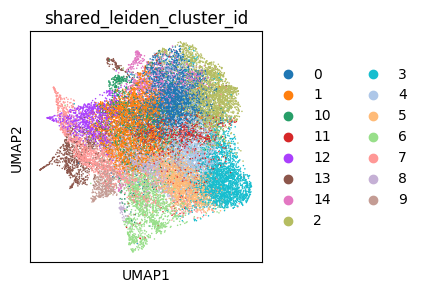

In [49]:
sc.pl.umap(adata_codex, color="shared_leiden_cluster_id")

### Read scRNA-seq data

In [50]:
adata_scrnaseq = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")
adata_scrnaseq.obsm["X_umap"] = adata_scrnaseq.obsm["UMAP"]
sc.pp.subsample(adata_scrnaseq, 0.3)

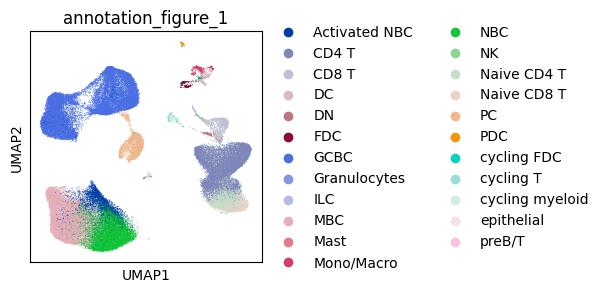

In [51]:
sc.pl.umap(adata_scrnaseq, color="annotation_figure_1")

## Test pushforward

Workig with cluster 0


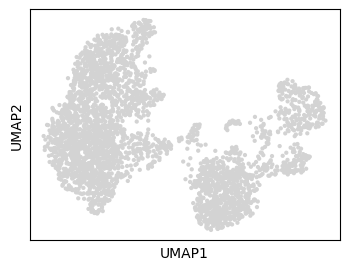

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


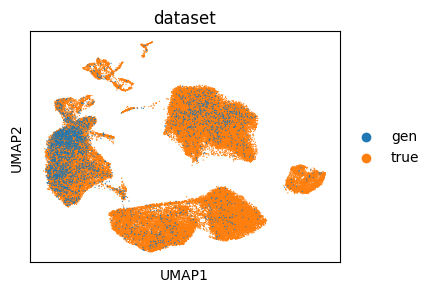

Workig with cluster 1


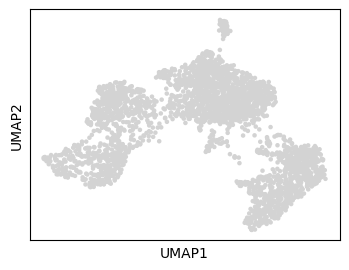

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


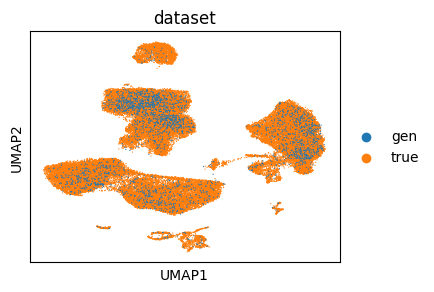

Workig with cluster 2


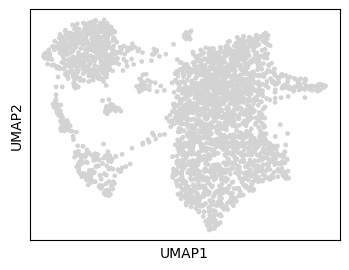

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


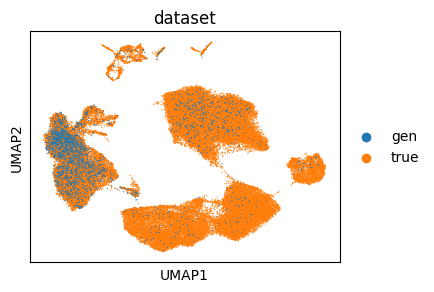

Workig with cluster 3


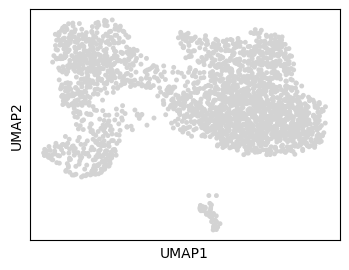

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


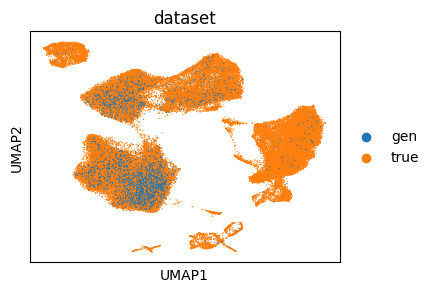

Workig with cluster 4


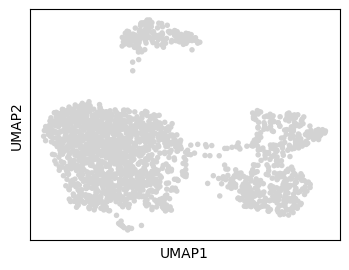

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


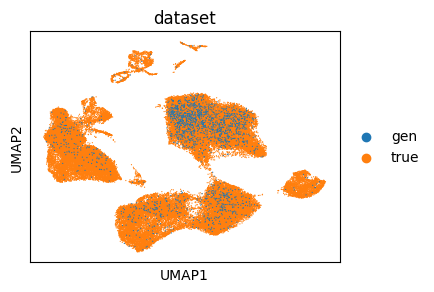

Workig with cluster 5


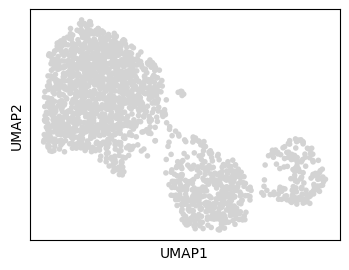

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


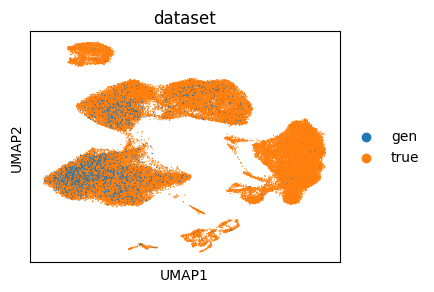

Workig with cluster 6


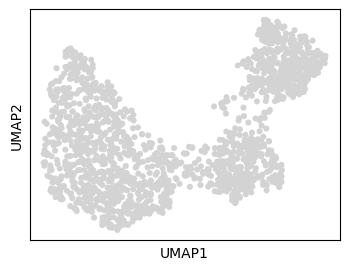

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


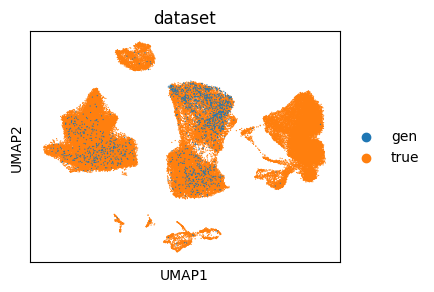

Workig with cluster 7


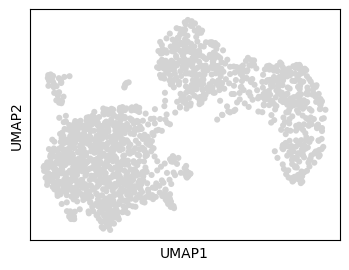

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


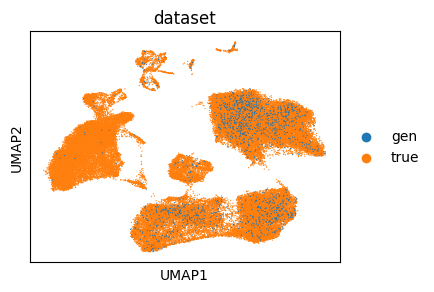

Workig with cluster 8


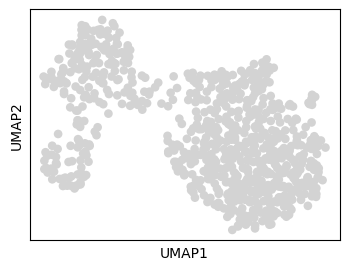

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


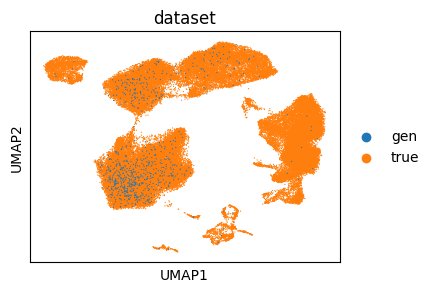

Workig with cluster 9


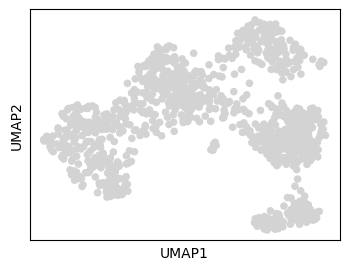

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


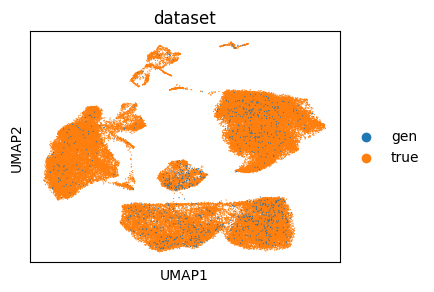

Workig with cluster 10


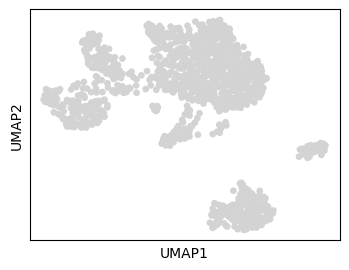

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


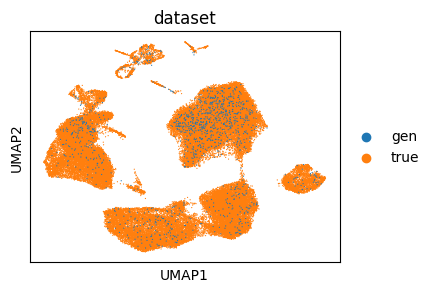

Workig with cluster 11


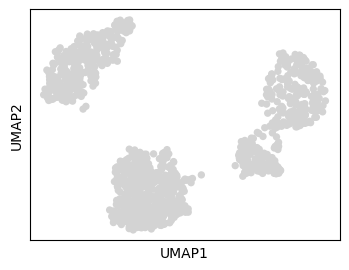

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


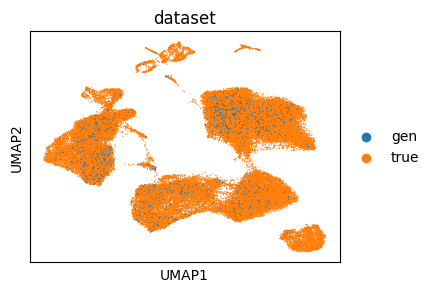

Workig with cluster 12


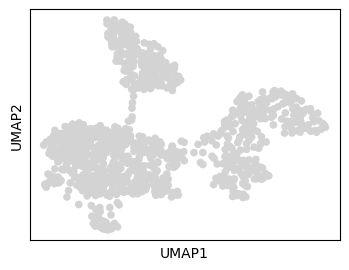

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


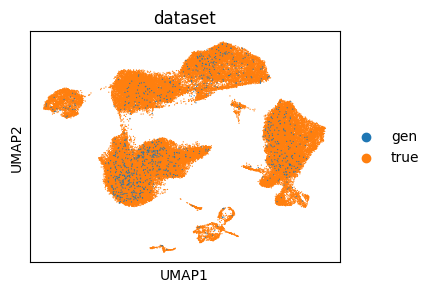

In [22]:
# Push forward every cluster 
for cl_id in range(13):
    print(f"Workig with cluster {cl_id}")
    X_codex = torch.from_numpy(adata_codex[adata_codex.obs.shared_leiden_cluster_id==str(cl_id)].X)
    hat_adata_rna = model.pushforward(x0=X_codex,
                                        n_timesteps = 2,
                                        solver = "dopri5")
    
    hat_adata_rna = hat_adata_rna.detach().cpu().numpy()
    hat_adata_rna_adata = sc.AnnData(X=hat_adata_rna)
    sc.tl.pca(hat_adata_rna_adata)
    sc.pp.neighbors(hat_adata_rna_adata)
    sc.tl.umap(hat_adata_rna_adata)
    sc.pl.umap(hat_adata_rna_adata)
    
    X_tot = np.concatenate([adata_scrnaseq.obsm["HARMONY"], hat_adata_rna], axis=0)
    obs = {"dataset": ["true" for _ in range(adata_scrnaseq.shape[0])] + ["gen" for _ in range(hat_adata_rna.shape[0])]}
    obs = pd.DataFrame(obs)
    adata_joint = sc.AnnData(X=X_tot, obs=obs)
    sc.tl.pca(adata_joint)
    sc.pp.neighbors(adata_joint)
    sc.tl.umap(adata_joint)
    sc.pl.umap(adata_joint, color="dataset", s=3)

## Analyze assignment 

In [52]:
# Step 1: Wrap the CODEX data in a PyTorch Dataset
class CodexDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data.X).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Step 2: Define cluster assignment via nearest neighbors
def cluster_assignment(X_hat, X_true, true_annot):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto')
    nn_model.fit(X_true)
    _, indices = nn_model.kneighbors(X_hat)
    return true_annot[indices.flatten()]

In [53]:
# Step 3: Prepare data and loader
codex_dataset = CodexDataset(adata_codex)
codex_loader = DataLoader(codex_dataset, batch_size=1000, shuffle=False)

real_annot = np.array(adata_scrnaseq.obs.annotation_figure_1)
X_true = adata_scrnaseq.obsm["HARMONY"]  # assumed (n_cells_rna, n_features)

# Step 4: Run inference and assignment in batches
assigned_annots = []

for batch in codex_loader:
    X_codex = batch  # already a torch tensor
    X_rna_hat = model.pushforward(
        x0=X_codex,
        n_timesteps=2,
        solver="dopri5"
    ).detach().cpu().numpy()

    batch_annots = cluster_assignment(X_rna_hat, X_true, real_annot)
    assigned_annots.append(batch_annots)

# Step 5: Concatenate all annotations
assigned_annots = np.concatenate(assigned_annots)

Examine results

In [54]:
adata_codex.obs["cell_type"] = assigned_annots

In [56]:
adata_codex.write_h5ad("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/predicted_codex/predicted_ct_healthy.h5ad")

In [36]:
# for cl in np.unique(adata_codex.obs.assigned_clusters):
#     sc.pl.umap(adata_codex,color="assigned_clusters", groups=[cl], palette="r")

## Check proportions 

0


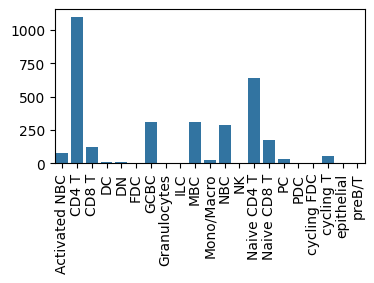

1


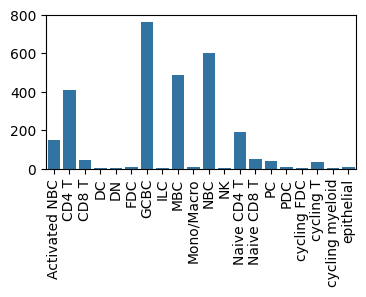

2


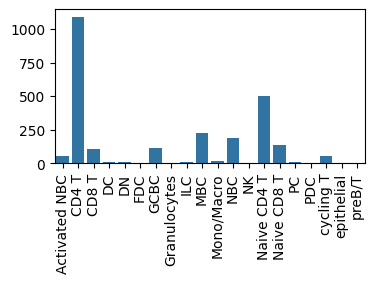

3


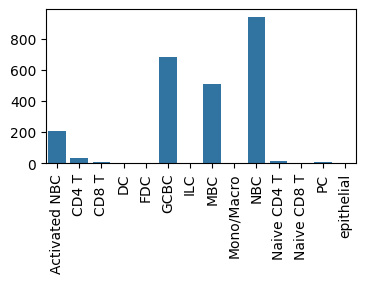

4


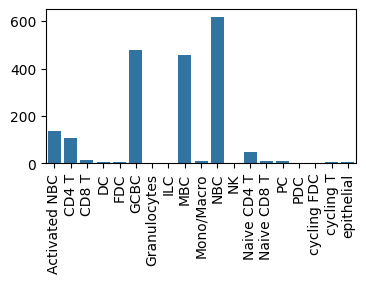

5


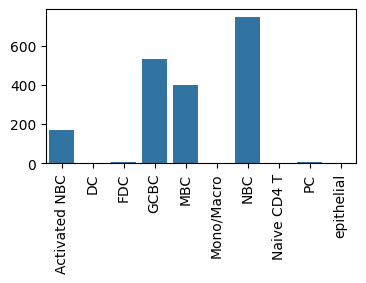

6


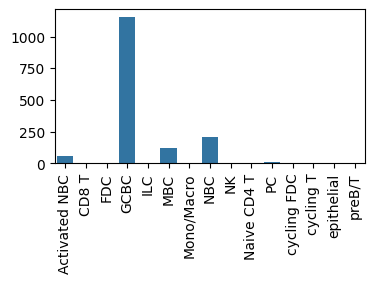

7


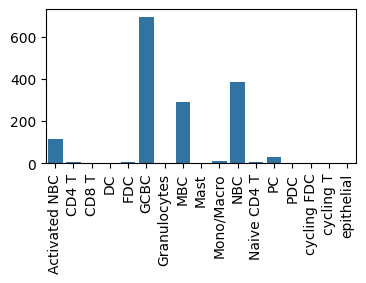

8


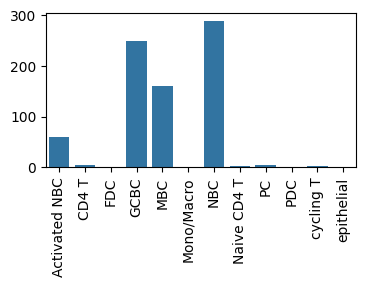

9


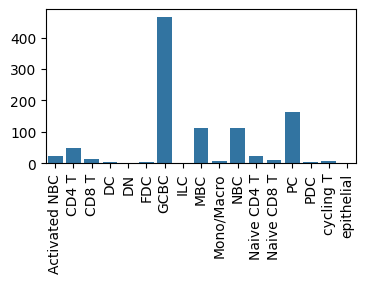

10


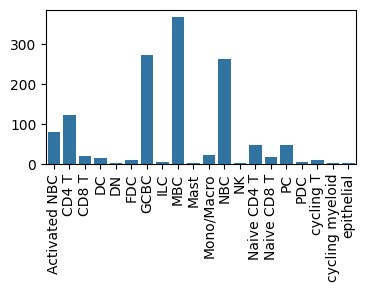

11


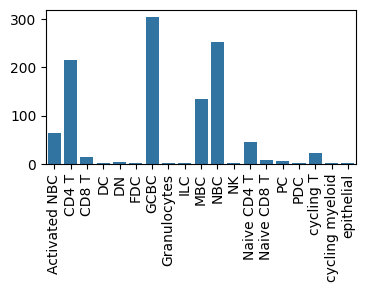

12


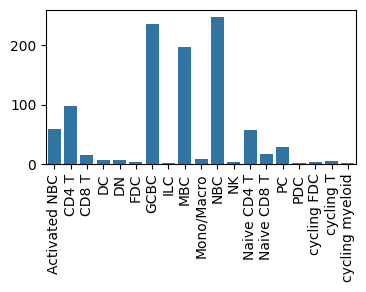

In [17]:
for cl_id in range(13):
    adata_cl = adata_codex[adata_codex.obs.shared_leiden_cluster_id==str(cl_id)]
    proportions_cl = np.unique(adata_cl.obs.assigned_clusters, return_counts=True)
    
    plt.figure(figsize=(4, 2))
    sns.barplot(x=proportions_cl[0], y=proportions_cl[1])

    # Add labels and show plot
    print(cl_id)
    plt.xticks(rotation=90)
    plt.show()